In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import h5py
file_path = "ev0000364000.h5"

In [3]:
# Open the file
f = h5py.File(file_path, 'r')
f

<HDF5 file "ev0000364000.h5" (mode r)>

In [4]:
# List all the attributes for the file
list(f.attrs.keys())

['ele', 'lat', 'lon', 'mag', 'time']

In [5]:
# List of the stations
list(f.keys())

['IWEH', 'KI2H', 'MKJH', 'NMEH']

In [6]:
# Shape of the data for a station
dset = f['IWEH']
dset.shape

(3, 270000000)

In [7]:
dset.shape[1]/(100*60*60*24)

31.25

In [8]:
# List of attributes for the station
list(dset.attrs.keys())

['dist_m', 'ele', 'lat', 'lon']

In [9]:
# Access the distance in meters of the station from the event
print(dset.attrs['dist_m'],
dset.attrs['ele'],
dset.attrs['lat'],
dset.attrs['lon'])

0120189 -145 37.0264 140.9702


In [10]:
# Find the distance for all the stations
for k in f.keys():
    print(k,f[k].attrs['dist_m'])

IWEH 0120189
KI2H 0149570
MKJH 0149240
NMEH 0128023


In [12]:
# Extract a portion of the data from numerous stations

import numpy as np

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH','NMEH']

# Start and end index values for the portion of data to extract
# 24*3600*100 is 24 hours of data at 100 Hzone day of data.
# this example outputs firt hour of second day:
start = 24*3600*100
end = 25*3600*100

# Number of channels
num_channels = 3

# Allocate the space to save the extracted data
data = np.empty((len(stations_list),num_channels,end-start,))

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = f[stations_list[i]][0:num_channels,start:end]
    
print(data.shape)

(4, 3, 360000)


In [ ]:
# Save the extracted data to file
np.save('data.npy', data)

In [14]:
%matplotlib notebook
from matplotlib import pyplot as plt

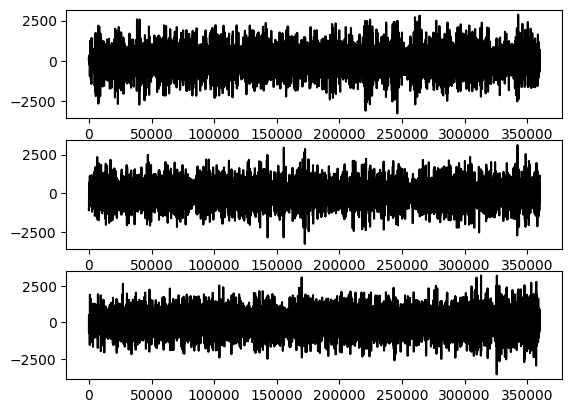

In [13]:
fig,ax=plt.subplots(3)
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,:],'k-')

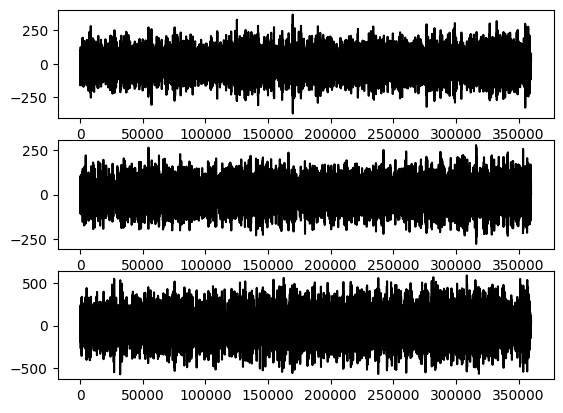

In [24]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH','NMEH']

# Number of channels
num_channels = 3
# Apply 1 Hz high-pass filter
fs = 100 # Hz, sampling rate of the data
cutoff_freq = 1 # Hz
order = 4 # filter order

b_hp, a_hp = butter(order, cutoff_freq / (fs / 2), btype='highpass')

# Apply bandpass filter
lowcut = 5/fs # Hz, lower cutoff frequency
highcut = 200/fs # Hz, higher cutoff frequency

b_bp, a_bp = butter(order, [lowcut / (fs / 2), highcut / (fs / 2)], btype='bandpass')

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = filtfilt(b_bp, a_bp, data[i,0:num_channels,:])
%matplotlib inline
fig,ax=plt.subplots(3)
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,:],'k-')



In [25]:
squared_data = data[0, 0, :] ** 2
integral = np.trapz(squared_data)


In [26]:
print(integral)

2508588783.1364403


In [30]:
from scipy.integrate import cumulative_trapezoid
# Calculate integral of the squared waveform
int_sqr = cumulative_trapezoid(data[0, 0, :]**2, dx=1/fs)[-1]



In [31]:
print(int_sqr)

25085887.831364475


In [32]:
data.shape

(4, 3, 360000)

In [41]:
from scipy import signal
import numpy as np

# Define the features to extract
features = ['int_sqr', 'max_spec_amp', 'freq_at_max_spec', 'center_freq', 'signal_bandwidth', 'zcr', 'spectral_peak_rate']

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH','NMEH']

# Number of channels
num_channels = 3

# Apply 1 Hz high-pass filter
fs = 100 # Hz, sampling rate of the data
cutoff_freq = 1 # Hz
order = 4 # filter order

b_hp, a_hp = signal.butter(order, cutoff_freq / (fs / 2), btype='highpass')

# Apply bandpass filter
lowcut = 5/(fs*0.5) # Hz, lower cutoff frequency
highcut = 200/(fs*0.5) # Hz, higher cutoff frequency

b_bp, a_bp = signal.butter(order, [lowcut / (fs / 2), highcut / (fs / 2)], btype='bandpass')

# Loop through each station and extract the features
for i in range(len(stations_list)):
    
    # Apply filters to the data
    data[i,0:num_channels,:] = signal.filtfilt(b_bp, a_bp, data[i,0:num_channels,:])
    
    # Initialize an empty feature vector
    feature_vector = np.zeros(len(features))
    
    # Loop through each channel and extract features
    for j in range(num_channels):
        
        # Compute the time-domain features
        waveform = data[i,j,:]
        dt = 1 / fs
        t = np.arange(0, len(waveform)) * dt
        int_sqr = np.trapz(waveform**2, t)
        zcr = np.mean(np.abs(np.diff(np.sign(waveform)))) / (2*dt)
        
        # Compute the frequency-domain features
        f, psd = signal.welch(waveform, fs=fs, nperseg=1024)
        max_spec_amp = np.max(psd)
        freq_at_max_spec = f[np.argmax(psd)]
        spec_centroid = np.sum(f * psd) / np.sum(psd)
        spec_bandwidth = np.sqrt(np.sum((f - spec_centroid)**2 * psd) / np.sum(psd))
        peaks, _ = signal.find_peaks(psd)
        spectral_peak_rate = len(peaks) / (f[-1] - f[0])
        
        # Append the features to the feature vector
        feature_vector = np.zeros(num_channels * 7)

        feature_vector[j*7:(j+1)*7] = [int_sqr, max_spec_amp, freq_at_max_spec, spec_centroid, spec_bandwidth, zcr, spectral_peak_rate]
    
    # Print the feature vector for the current station
    print(f"Features for station {stations_list[i]}: {feature_vector[14:21]}")


Features for station IWEH: [9.69988953e+07 8.20494432e+04 5.85937500e-01 6.84010932e-01
 1.60383369e-01 1.40778169e+00 2.00000000e-02]
Features for station KI2H: [9.28077764e+05 7.51525520e+02 5.85937500e-01 6.90128254e-01
 1.98471940e-01 1.37278159e+00 6.00000000e-02]
Features for station MKJH: [4.92245778e+05 3.89802490e+02 6.83593750e-01 7.14676416e-01
 2.09781896e-01 1.40805947e+00 4.00000000e-02]
Features for station NMEH: [3.64650039e+07 1.90874145e+04 6.83593750e-01 8.86096214e-01
 2.45970758e-01 1.83472732e+00 4.00000000e-02]


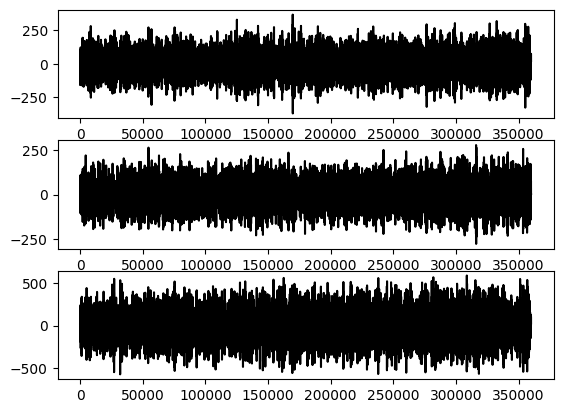

In [36]:
%matplotlib inline
fig,ax=plt.subplots(3)
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,:],'k-')
